In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from typing import Dict, Callable

### optimization

In [2]:
class SGD:
    def __init__(self, lr:float=0.01):
        self.lr: float = lr
    
    def update(self, params: Dict, grads: npt.NDArray[np.float64]):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [3]:
class Momentum:
    def __init__(self, lr:float=0.01, momentum:float=0.9):
        self.lr: float = lr
        self.momentum: float = momentum
        self.v: npt.NDArray[np.float64] = None

    def update(self, params: Dict, grads: Dict):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [4]:
class AdaGrad:
    def __init__(self, lr:float=0.01):
        self.lr: float = lr
        self.h: Dict = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [5]:
# The Adam optimizer motivated by 'Momentum' and 'RMSProp'. 
# So the Adam optimizer can accelerate the gradient descent algorithm and use an adaptive learning for each parameter.
class Adam:
    def __init__(lr:float=0.001, beta1:float=0.9, beta2:float=0.999):
        self.lr: float = lr
        self.beta1: float = beta1
        self.beta2: float = beta2
        self.iter: int = 0
        self.m: Dict = None
        self.v: Dict = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

### optimizer's performance (with MNIST dataset)

===========iteration:0===========
SGD:2.374784793200515
Momentum:2.2650950075793572
AdaGrad:1.933503958018224
Adam:2.2097866284423096
===========iteration:100===========
SGD:1.884752587583821
Momentum:0.3044776417352498
AdaGrad:0.16623205366378246
Adam:0.2539959645129116
===========iteration:200===========
SGD:0.9401812579879613
Momentum:0.2204149053646865
AdaGrad:0.0770818341182331
Adam:0.15231202552199136
===========iteration:300===========
SGD:0.5996724828835127
Momentum:0.19715721317375764
AdaGrad:0.11015276916764967
Adam:0.14747211427094342
===========iteration:400===========
SGD:0.5162442654105489
Momentum:0.11024832145697935
AdaGrad:0.04205138958126677
Adam:0.08358740920278013
===========iteration:500===========
SGD:0.5496201045052816
Momentum:0.19870439415595456
AdaGrad:0.11670395593380334
Adam:0.17455198836493369
===========iteration:600===========
SGD:0.39598367458646333
Momentum:0.13395005627736992
AdaGrad:0.07141161024781335
Adam:0.08192995494989777
===========iteration:700

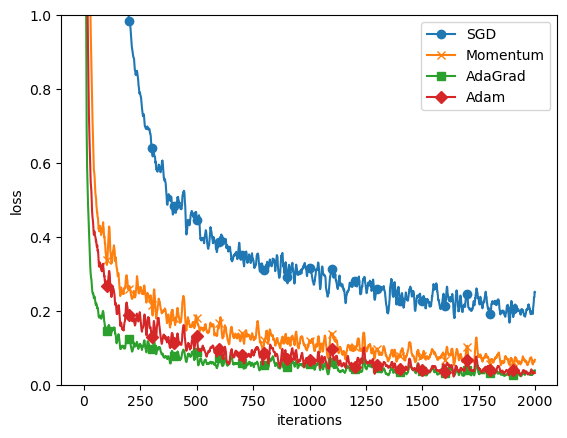

In [6]:
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

### histgram of Weight initialization and Activation function

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

In [8]:
def weight_init_activation_histogram(w: npt.NDArray, w_idx: int, activation_func: Callable, acti_func_idx: int):
    input_data = np.random.randn(1000, 100)  # 1000개의 데이터

    hidden_layer_size = 5  # 은닉층이 5개
    activations = {}  # 이곳에 활성화 결과를 저장

    x = input_data

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        a = np.dot(x, w)

        z = activation_func(a)
        activations[i] = z

    # 히스토그램 그리기
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0,1))

    # 타이틀 이름 붙이기
    title_name = ''

    if w_idx == 0:
        title_name += 'weight init : std 1, '
    elif w_idx == 1:
        title_name += 'weight init : std 0.01, '
    elif w_idx == 2:
        title_name += 'weight init : Xavier, '
    else:
        title_name += 'weight init : He, '

    if acti_func_idx == 0:
        title_name += 'activation function : sigmoid'
    elif acti_func_idx == 1:
        title_name += 'activation function : ReLU'
    else:
        title_name += 'activation function : tanh'
    
    plt.suptitle(f'< {title_name} >')

    plt.show()

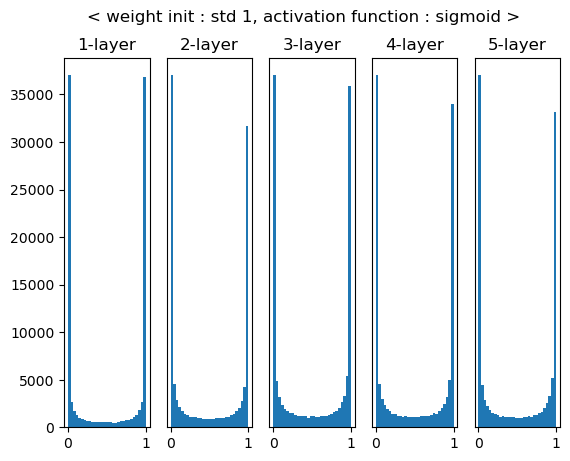

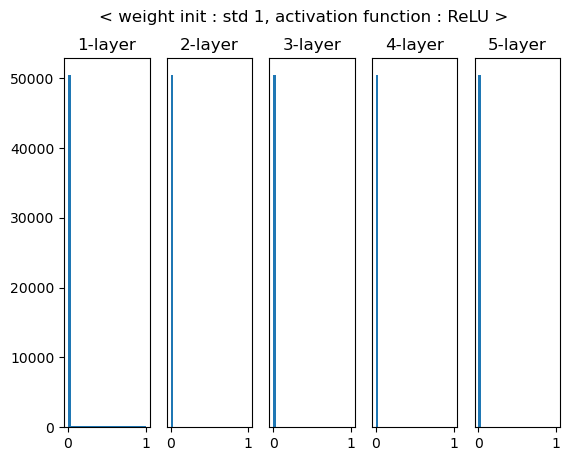

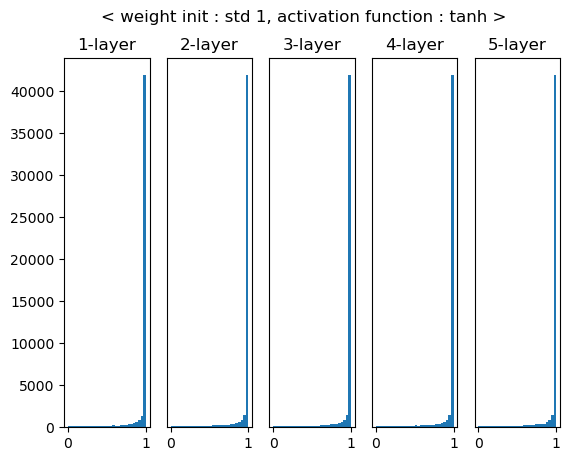

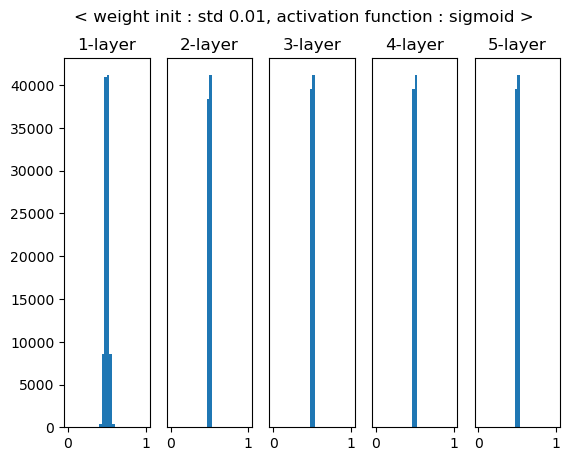

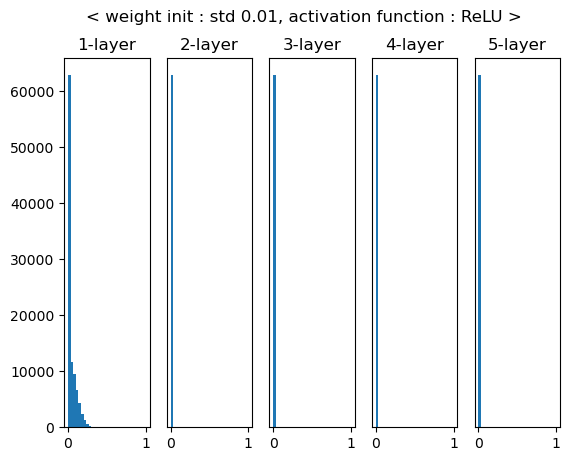

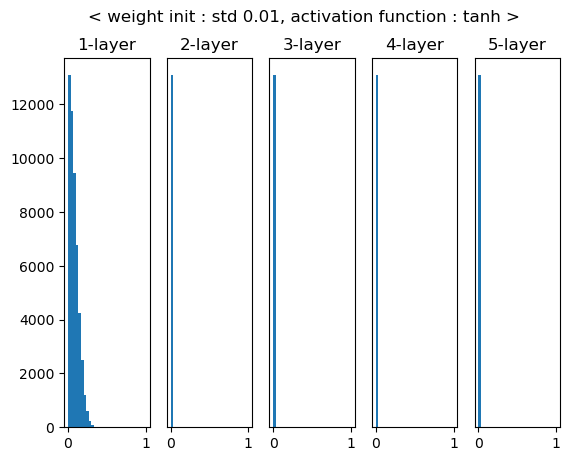

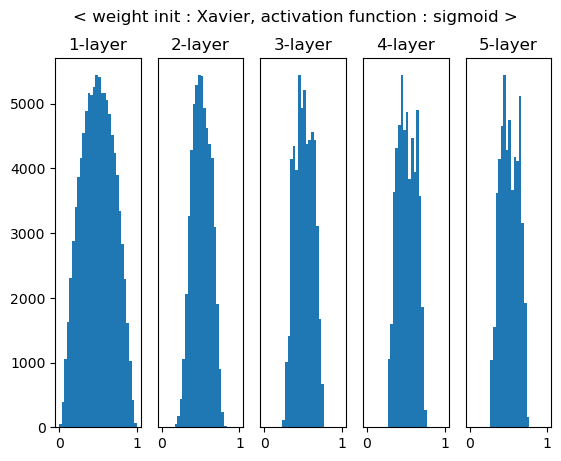

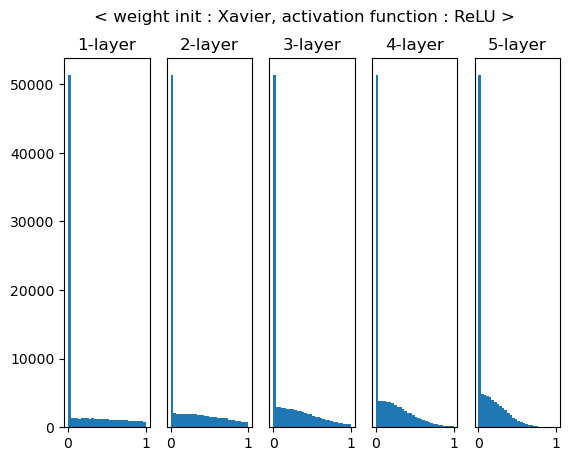

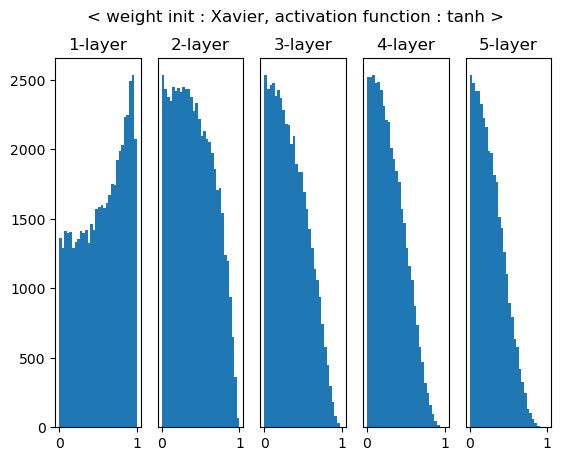

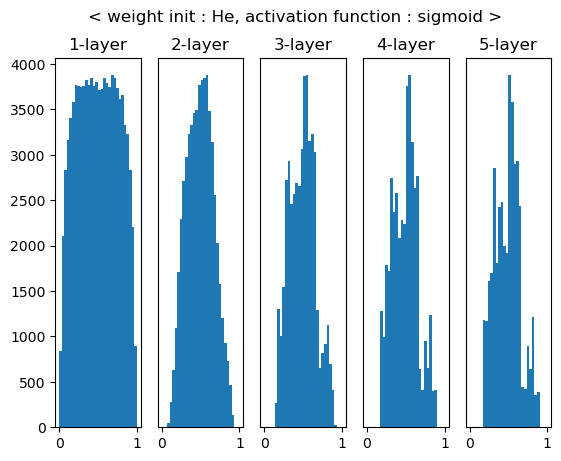

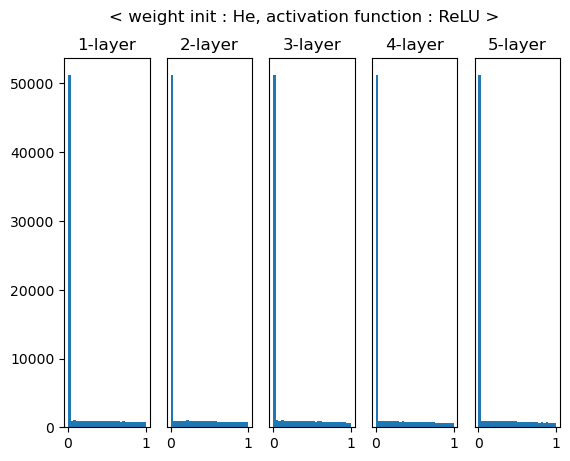

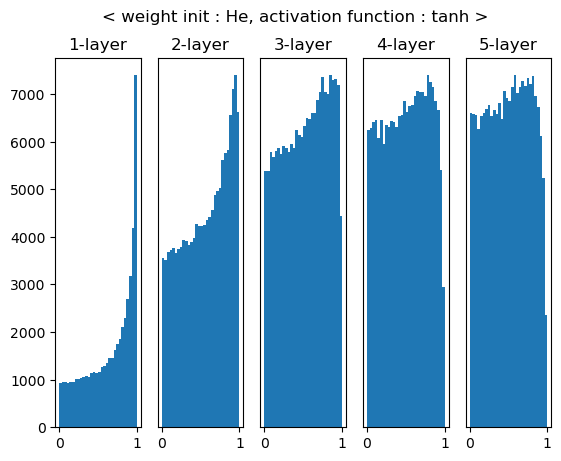

In [9]:
# 각 은닉층의 노드(뉴런) 수
node_num = 100

w_li = [np.random.randn(node_num, node_num) * 1, np.random.randn(node_num, node_num) * 0.01,
        np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num), 
        np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)]

activation_func_li = [sigmoid, ReLU, tanh]

for w_idx, w in enumerate(w_li):
    for acti_func_idx, acti_func in enumerate(activation_func_li):
        weight_init_activation_histogram(w, w_idx, acti_func, acti_func_idx)

### initialization weight's performance (with MNIST dataset)

===========iteration:0===========
std=0.01:2.302520456278403
Xavier:2.284928104179639
He:2.320485418533397
===========iteration:100===========
std=0.01:2.3025609550376256
Xavier:2.2131792464943736
He:1.6142471951056387
===========iteration:200===========
std=0.01:2.3036551125248828
Xavier:1.9968630876609683
He:0.7569591754852676
===========iteration:300===========
std=0.01:2.297729624406357
Xavier:1.5577962440102437
He:0.45016155468235913
===========iteration:400===========
std=0.01:2.302657243995414
Xavier:0.9307275303061674
He:0.3161177118492543
===========iteration:500===========
std=0.01:2.301906834972244
Xavier:0.7533069469923228
He:0.42006221219461787
===========iteration:600===========
std=0.01:2.303340109070021
Xavier:0.4994667270449041
He:0.2619533190205508
===========iteration:700===========
std=0.01:2.3019698894598646
Xavier:0.5318500274991704
He:0.3337764560833104
===========iteration:800===========
std=0.01:2.296181460776641
Xavier:0.4386064496441462
He:0.2605810271148882


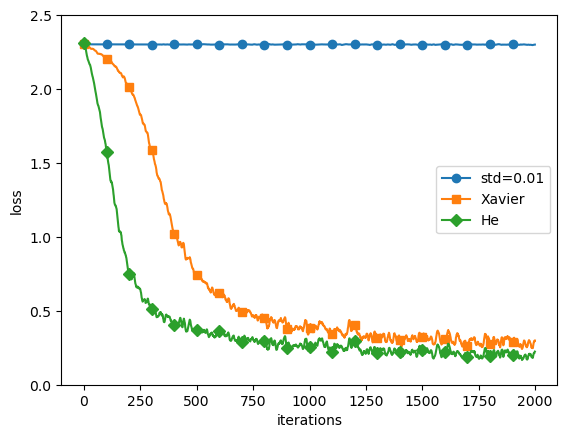

In [10]:
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### batch normalization's performance (with MNIST dataset)

============== 1/16 ==============
epoch:0 | 0.097 - 0.086
epoch:1 | 0.097 - 0.092
epoch:2 | 0.097 - 0.129
epoch:3 | 0.097 - 0.184


c:\Users\bigsm\Coding\Python\deep-learning-from-scratch-01\chapter_06\..\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
c:\Users\bigsm\Coding\Python\deep-learning-from-scratch-01\chapter_06\..\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in scalar multiply
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
c:\Users\bigsm\Coding\Python\deep-learning-from-scratch-01\chapter_06\..\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:4 | 0.097 - 0.213
epoch:5 | 0.097 - 0.236
epoch:6 | 0.097 - 0.259
epoch:7 | 0.097 - 0.279
epoch:8 | 0.097 - 0.294
epoch:9 | 0.097 - 0.311
epoch:10 | 0.097 - 0.328
epoch:11 | 0.097 - 0.352
epoch:12 | 0.097 - 0.378
epoch:13 | 0.097 - 0.402
epoch:14 | 0.097 - 0.421
epoch:15 | 0.097 - 0.427
epoch:16 | 0.097 - 0.449
epoch:17 | 0.097 - 0.459
epoch:18 | 0.097 - 0.469
epoch:19 | 0.097 - 0.47
============== 2/16 ==============
epoch:0 | 0.097 - 0.103
epoch:1 | 0.097 - 0.105
epoch:2 | 0.097 - 0.115
epoch:3 | 0.097 - 0.13
epoch:4 | 0.097 - 0.152
epoch:5 | 0.097 - 0.172
epoch:6 | 0.097 - 0.188
epoch:7 | 0.097 - 0.212
epoch:8 | 0.097 - 0.224
epoch:9 | 0.097 - 0.251
epoch:10 | 0.097 - 0.27
epoch:11 | 0.097 - 0.284
epoch:12 | 0.097 - 0.296
epoch:13 | 0.097 - 0.319
epoch:14 | 0.097 - 0.334
epoch:15 | 0.097 - 0.356
epoch:16 | 0.097 - 0.361
epoch:17 | 0.097 - 0.382
epoch:18 | 0.097 - 0.409
epoch:19 | 0.097 - 0.418
============== 3/16 ==============
epoch:0 | 0.149 - 0.126
epoch:1 | 0.38 - 0.099
ep

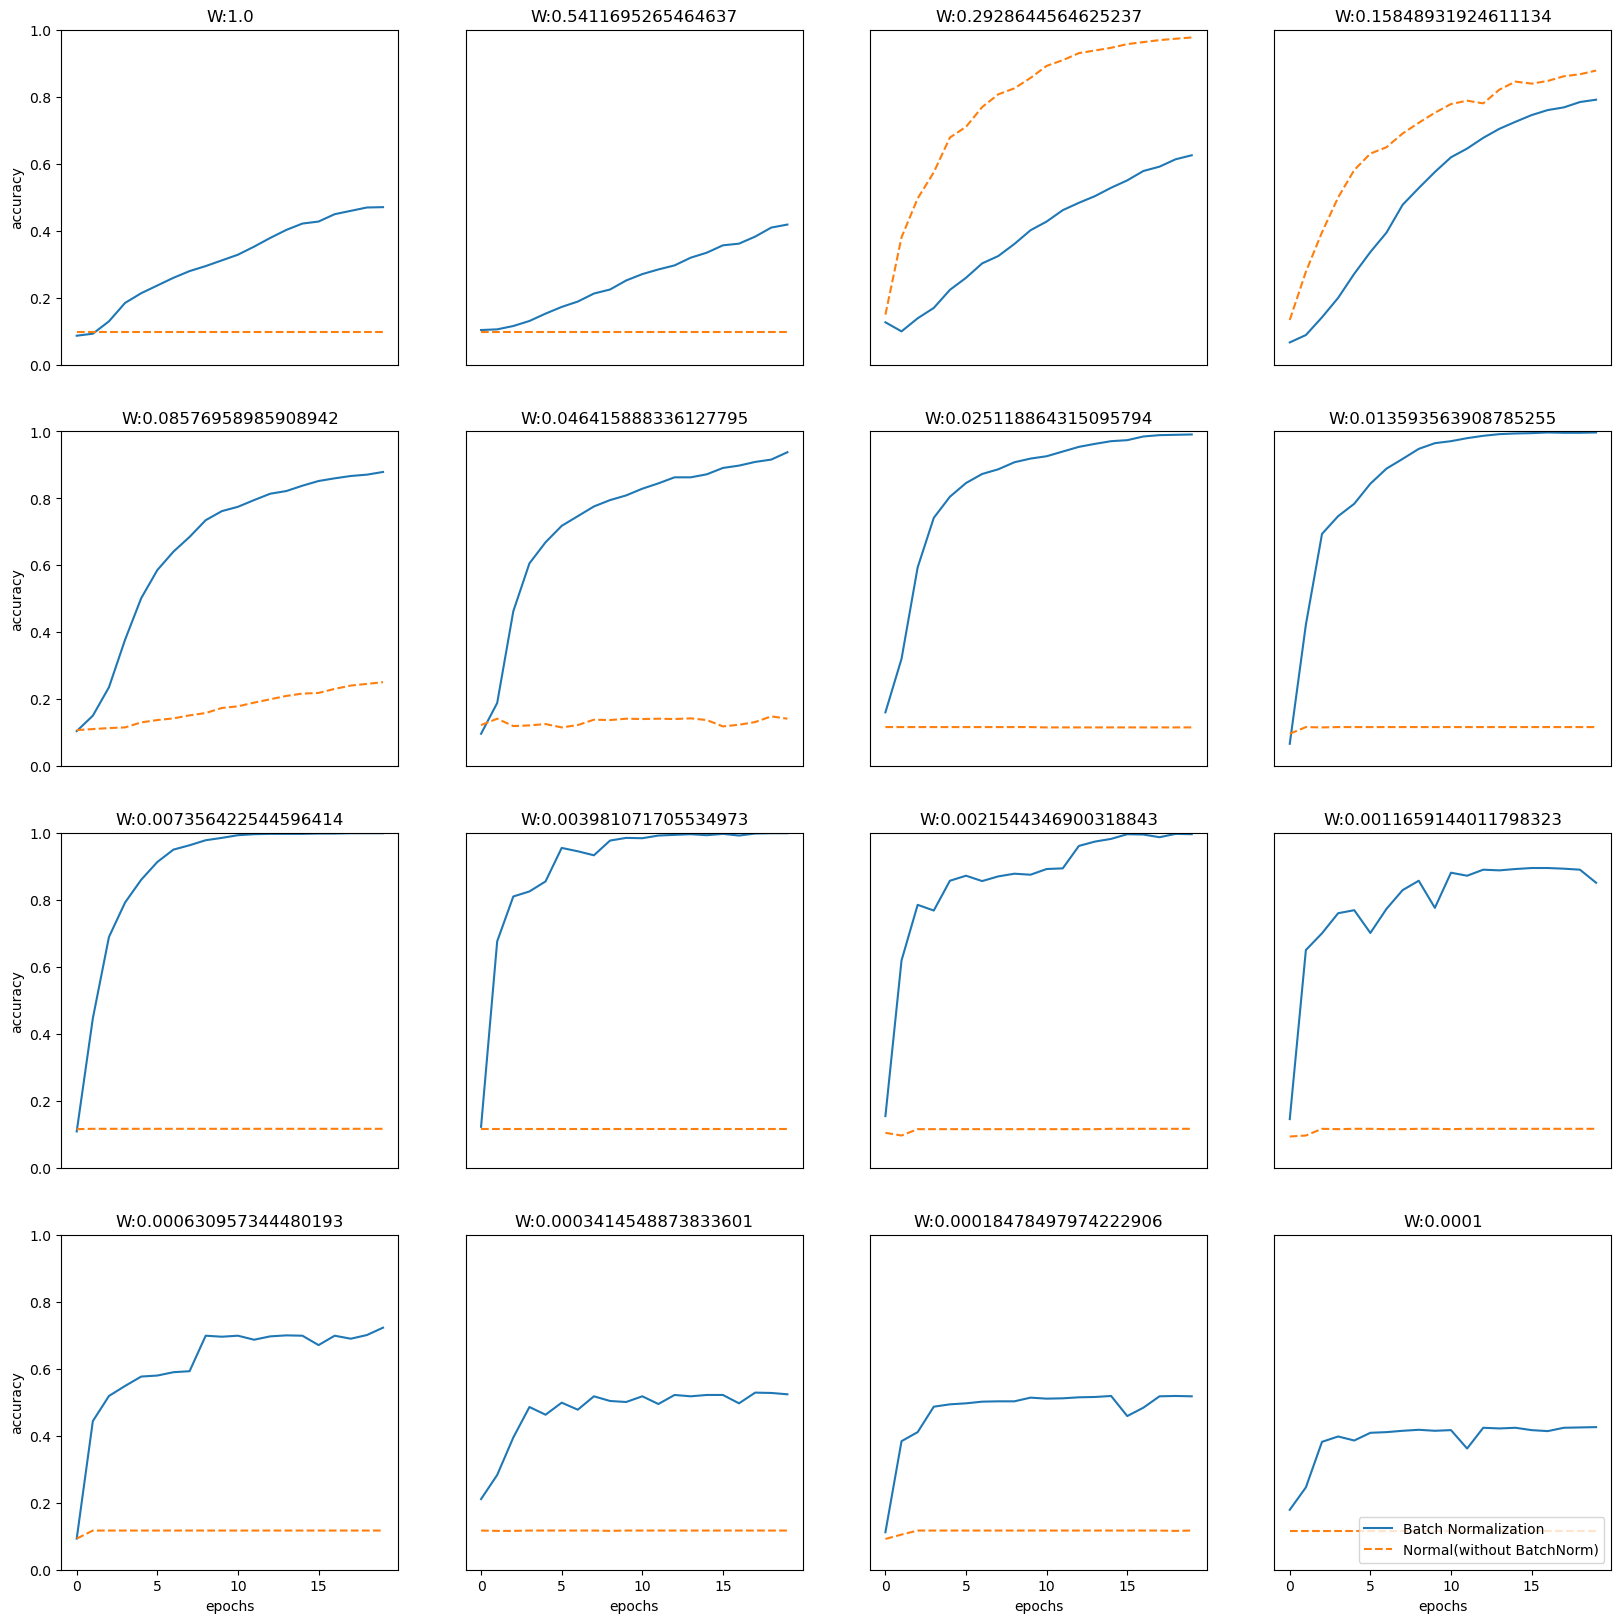

In [11]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

plt.figure(figsize=(20,20))
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    
plt.legend(loc='lower right')    
plt.show()

### weight decay

epoch:0, train acc:0.12, test acc:0.1185
epoch:1, train acc:0.12333333333333334, test acc:0.1296
epoch:2, train acc:0.15666666666666668, test acc:0.1518
epoch:3, train acc:0.22, test acc:0.1776
epoch:4, train acc:0.25, test acc:0.1932
epoch:5, train acc:0.28, test acc:0.2074
epoch:6, train acc:0.29, test acc:0.2154
epoch:7, train acc:0.29333333333333333, test acc:0.2189
epoch:8, train acc:0.33, test acc:0.2385
epoch:9, train acc:0.35, test acc:0.2482
epoch:10, train acc:0.36666666666666664, test acc:0.2559
epoch:11, train acc:0.39666666666666667, test acc:0.2666
epoch:12, train acc:0.41, test acc:0.271
epoch:13, train acc:0.43, test acc:0.2813
epoch:14, train acc:0.45, test acc:0.2937
epoch:15, train acc:0.4633333333333333, test acc:0.3073
epoch:16, train acc:0.47, test acc:0.3149
epoch:17, train acc:0.48, test acc:0.3228
epoch:18, train acc:0.49333333333333335, test acc:0.3322
epoch:19, train acc:0.5166666666666667, test acc:0.3457
epoch:20, train acc:0.5333333333333333, test acc:0.35

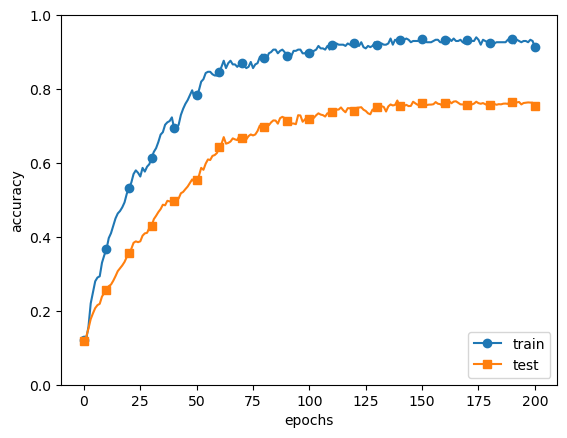

In [12]:
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### dropout

train loss:2.3068585106995685
=== epoch:1, train acc:0.11666666666666667, test acc:0.1244 ===
train loss:2.302881099388924
train loss:2.3201633603706715
train loss:2.295323316016422
=== epoch:2, train acc:0.11333333333333333, test acc:0.1265 ===
train loss:2.3176290086494644
train loss:2.318911516806044
train loss:2.313033621771417
=== epoch:3, train acc:0.11666666666666667, test acc:0.1302 ===
train loss:2.3016570581073057
train loss:2.300442544552937
train loss:2.3173624165072444
=== epoch:4, train acc:0.12333333333333334, test acc:0.1306 ===
train loss:2.3235283290949993
train loss:2.2849207009275765
train loss:2.316500751651118
=== epoch:5, train acc:0.13333333333333333, test acc:0.1345 ===
train loss:2.3060572140858278
train loss:2.2974995295684555
train loss:2.305829533699188
=== epoch:6, train acc:0.13333333333333333, test acc:0.1346 ===
train loss:2.3340502019565523
train loss:2.29646843325721
train loss:2.3003116451280956
=== epoch:7, train acc:0.12333333333333334, test acc:0.

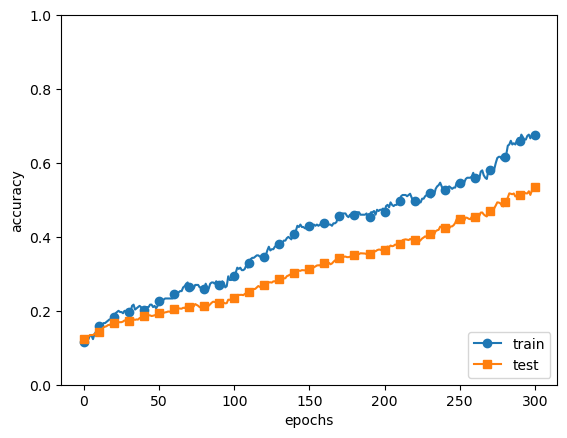

In [13]:
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비율 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### hyperparameter optimization

val acc:0.09 | lr:4.092775826712662e-06, weight decay:5.796964761988239e-07
val acc:0.74 | lr:0.00779610206970648, weight decay:6.618361331705945e-08
val acc:0.72 | lr:0.007519903954603383, weight decay:2.9926742780928976e-05
val acc:0.1 | lr:1.148868494678002e-06, weight decay:6.695890092515521e-08
val acc:0.11 | lr:3.03532512162431e-05, weight decay:5.038316923357487e-06
val acc:0.14 | lr:1.0036872661383207e-05, weight decay:5.701687113822342e-08
val acc:0.8 | lr:0.009339884638515254, weight decay:7.446510872767303e-07
val acc:0.39 | lr:0.002476762008439645, weight decay:9.8812173171201e-07
val acc:0.12 | lr:4.568863670453136e-05, weight decay:3.010416150454685e-08
val acc:0.29 | lr:0.0019045089932118583, weight decay:6.885663424903737e-05
val acc:0.17 | lr:0.0010256206867545665, weight decay:6.334730212728939e-08
val acc:0.15 | lr:0.0006141706174266669, weight decay:3.0698307251487665e-08
val acc:0.36 | lr:0.002096513259865796, weight decay:8.866648683133556e-06
val acc:0.09 | lr:2.

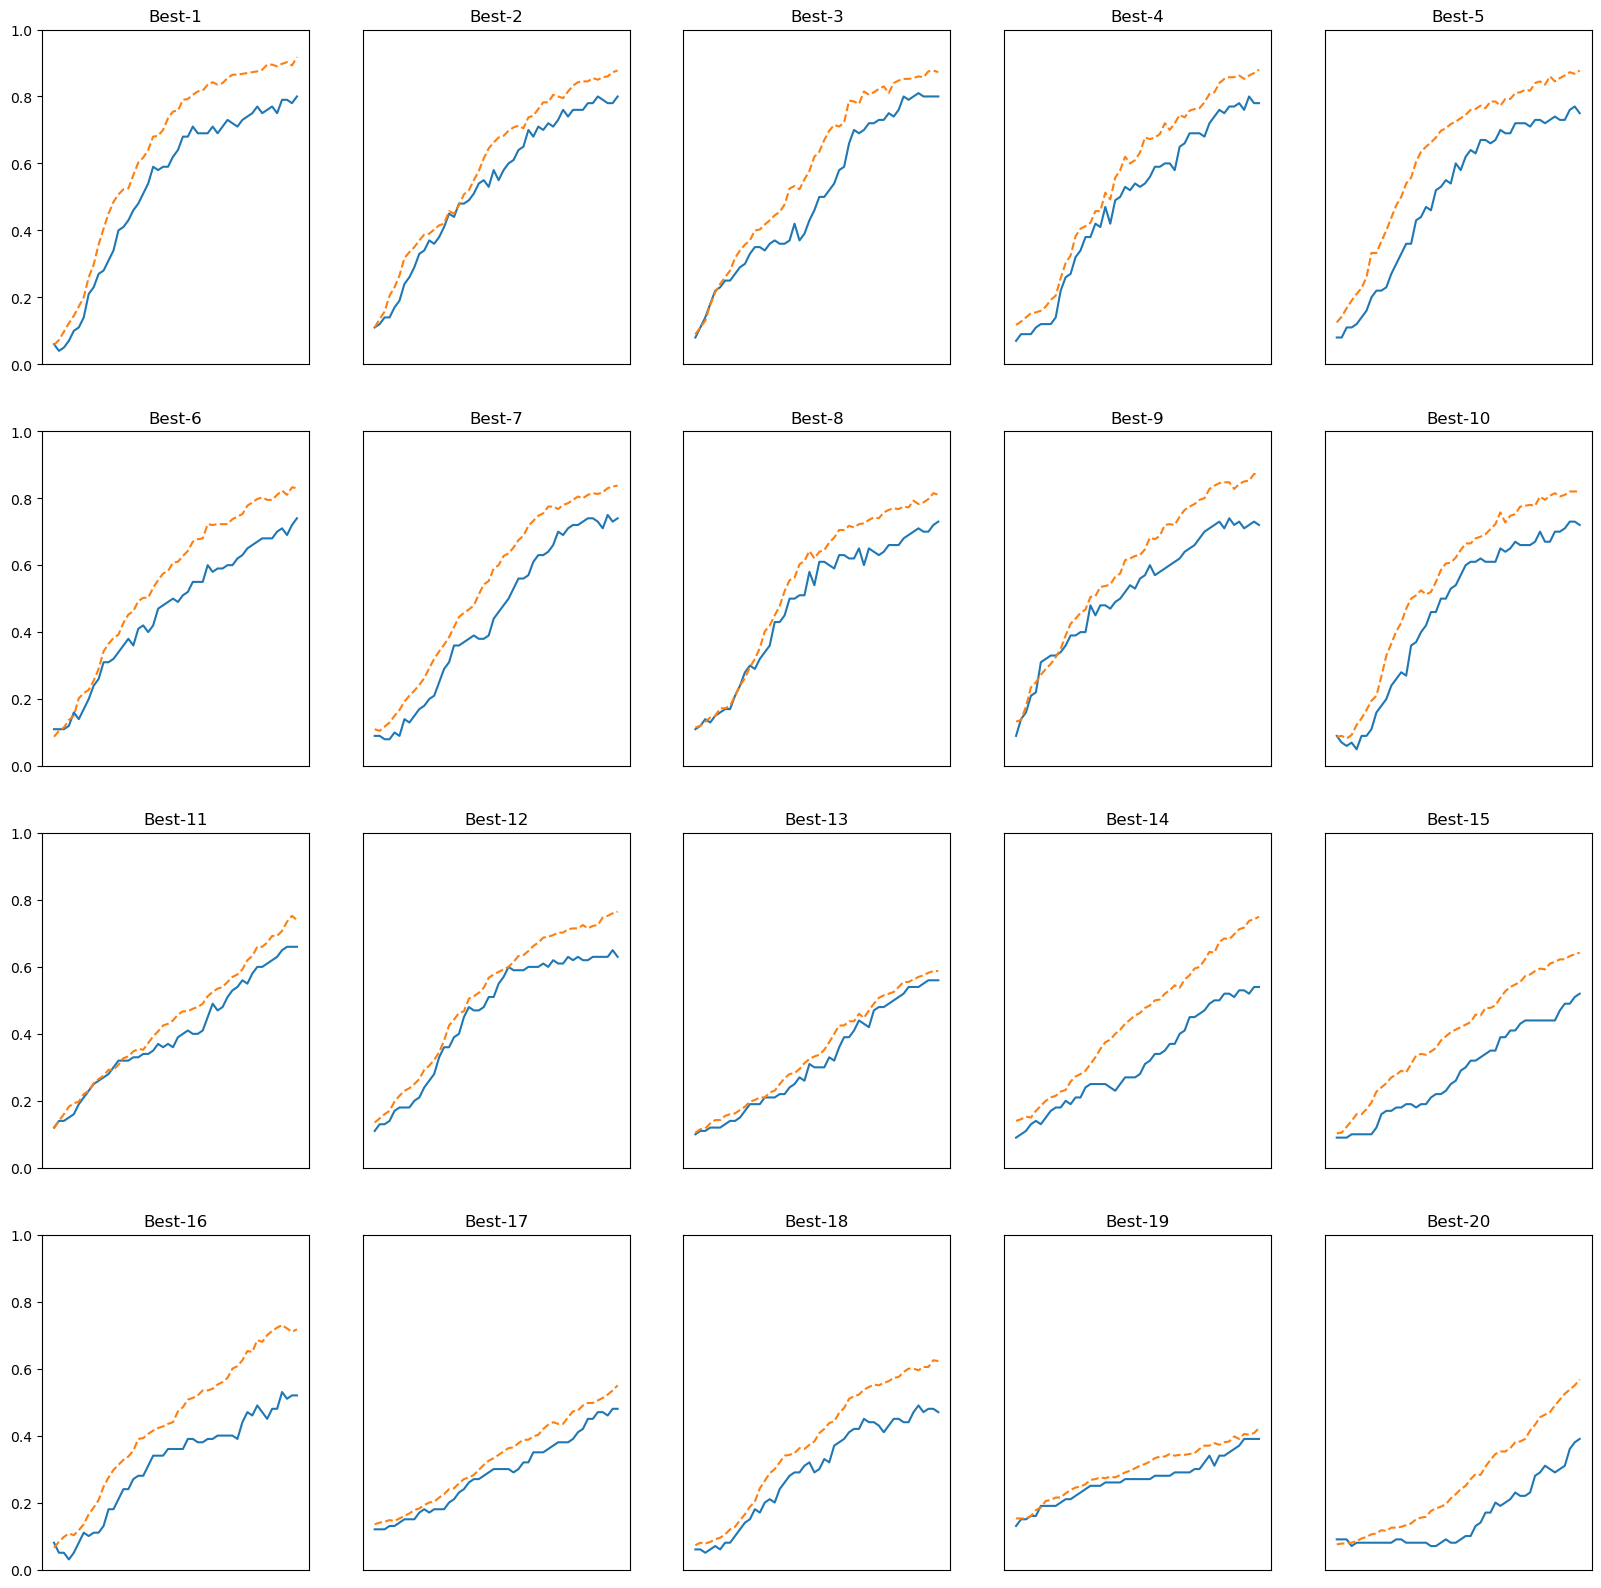

In [14]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.figure(figsize=(20,20))
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()